## Import some python packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import joblib  # For saving and loading model
import time

## Load the data

In [2]:
Xd = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

## Split the data into training and test sets

In [3]:
 np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]

## Convert the dependent variables (labels) into one-hoe encoding format

In [4]:
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Check the maximum and minimum values in both training and test sets

In [6]:
np.max(X_train), np.min(X_train)

(0.16046731, -0.15494554)

In [7]:
np.max(X_test), np.min(X_test)

(0.16422912, -0.15118897)

## Flateen the 2D input into 1D vector

In [8]:
# X_train = X_train.reshape((X_train.shape[0], -1))

In [9]:
# X_test = X_test.reshape((X_test.shape[0], -1))

## Performing principal component analysis (PCA)

In [10]:
# P_components = 100

# pca = PCA(n_components = P_components, whiten = True)

# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.fit_transform(X_test)

## Build the ANN model

In [11]:
# model = models.Sequential()

# # model.add(Dense(64, input_shape = (X_train_pca.shape[1],), activation = 'tanh'))
# model.add(Dense(64, input_shape = (X_train.shape[1],), activation = 'relu'))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dense(16, activation = 'relu'))
# model.add(Dense(len(classes)))
# model.add(Activation('softmax'))
# model.summary()

In [12]:
model = models.Sequential()

# model.add(Dense(64, input_shape = (X_train_pca.shape[1],), activation = 'tanh'))
# model.add(Dense(128, input_shape = (X_train.shape[1],))) 
model.add(Dense(128, activation ='relu', input_shape = in_shp))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(256, activation ='relu'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(len(classes), activation = 'softmax'))
# model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            16512     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 128)            32896     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1419      
Total params: 116,747
Trainable params: 116,747
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
# model.fit(X_train_pca, y_train, batch_size = 128, steps_per_epoch = 110000//128, epochs = 5, verbose = 1,
#           validation_data = (X_test_pca, y_test), validation_batch_size = 128, validation_steps = 110000//128)
tic = time.time()
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, validation_data = (X_test, y_test), 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, 
                                               mode = 'auto', restore_best_weights = True)])
toc = time.time()
training_time = toc - tic

print ("The training time is %.3f seconds" %(training_time))

Epoch 1/100
108/108 [==============================] - 8s 59ms/step - loss: 2.3045 - accuracy: 0.1398 - val_loss: 2.0903 - val_accuracy: 0.2289
Epoch 2/100
108/108 [==============================] - 4s 34ms/step - loss: 1.9659 - accuracy: 0.2762 - val_loss: 1.7993 - val_accuracy: 0.3173
Epoch 3/100
108/108 [==============================] - 4s 34ms/step - loss: 1.7568 - accuracy: 0.3320 - val_loss: 1.6938 - val_accuracy: 0.3470
Epoch 4/100
108/108 [==============================] - 4s 36ms/step - loss: 1.6716 - accuracy: 0.3549 - val_loss: 1.6658 - val_accuracy: 0.3635
Epoch 5/100
108/108 [==============================] - 4s 33ms/step - loss: 1.6397 - accuracy: 0.3681 - val_loss: 1.6249 - val_accuracy: 0.3759
Epoch 6/100
108/108 [==============================] - 4s 33ms/step - loss: 1.5969 - accuracy: 0.3861 - val_loss: 1.6091 - val_accuracy: 0.3762
Epoch 7/100
108/108 [==============================] - 4s 33ms/step - loss: 1.5687 - accuracy: 0.3968 - val_loss: 1.5770 - val_accuracy:

## Print the test loss and accuracy

In [15]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3438/3438 [==============================] - 6s 2ms/step - loss: 1.4437 - accuracy: 0.4531
Test loss: 1.4437390565872192
Test accuracy: 0.4530909061431885


## Show classification report

In [16]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis = 1), y_predict))

C:\Users\Jerry\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.29      0.23      0.26      9991
           1       0.55      0.64      0.59     10041
           2       0.27      0.89      0.42      9915
           3       0.59      0.40      0.48      9841
           4       0.59      0.60      0.60     10076
           5       0.78      0.64      0.70     10067
           6       0.70      0.52      0.60     10086
           7       0.33      0.02      0.04     10024
           8       0.39      0.49      0.43      9920
           9       0.35      0.23      0.28      9998
          10       0.62      0.31      0.41     10041

    accuracy                           0.45    110000
   macro avg       0.50      0.45      0.44    110000
weighted avg       0.50      0.45      0.44    110000



## Show loss curves 

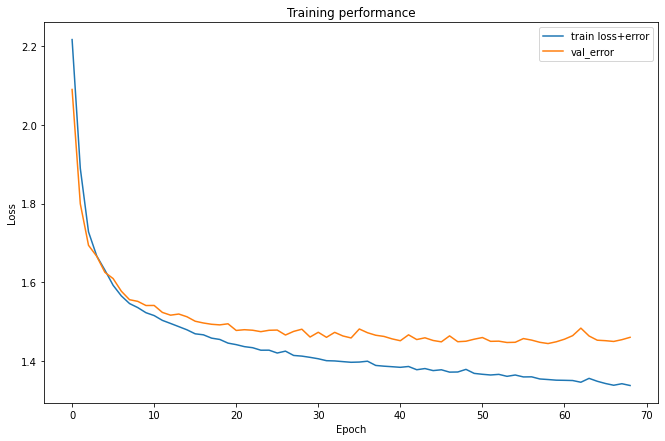

In [17]:
plt.figure(figsize = (11, 7))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Plot confusion matrix

In [52]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap = plt.cm.Blues, labels = []):
#     plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

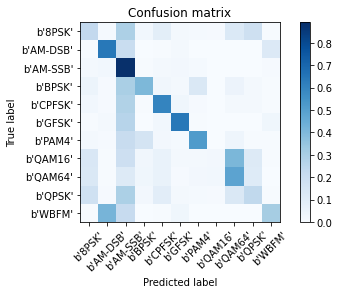

In [53]:
test_Y_hat = model.predict(X_test, batch_size = 1024)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])

for i in range(0, X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
    
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
plot_confusion_matrix(confnorm, labels = classes)

## Get the test accuracy for different SNRs

In [54]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx):
    acc = []
    
    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
#         test_SNRs = map(lambda x: lbl[x][1], test_idx)
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        
        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
            
        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
#         acc[snr] = 1.0*cor/(cor+ncor)
        acc.append(1.0*cor/(cor+ncor))
        
    return acc

Overall Accuracy:  0.09339080459770115 for SNR b'-20'
Overall Accuracy:  0.09655046541339661 for SNR b'-18'
Overall Accuracy:  0.10421925712225028 for SNR b'-16'
Overall Accuracy:  0.12564008778346744 for SNR b'-14'
Overall Accuracy:  0.17319034852546916 for SNR b'-12'
Overall Accuracy:  0.21041015265771565 for SNR b'-10'
Overall Accuracy:  0.2797707100591716 for SNR b'-8'
Overall Accuracy:  0.3838845240270418 for SNR b'-6'
Overall Accuracy:  0.4166367873789889 for SNR b'-4'
Overall Accuracy:  0.5274146695715323 for SNR b'-2'
Overall Accuracy:  0.6370819551635428 for SNR b'0'
Overall Accuracy:  0.673621190130624 for SNR b'2'
Overall Accuracy:  0.6623970722781336 for SNR b'4'
Overall Accuracy:  0.6741882223445239 for SNR b'6'
Overall Accuracy:  0.6675656238763035 for SNR b'8'
Overall Accuracy:  0.6629293468588717 for SNR b'10'
Overall Accuracy:  0.666120517021664 for SNR b'12'
Overall Accuracy:  0.6733393994540491 for SNR b'14'
Overall Accuracy:  0.6721969006381039 for SNR b'16'
Overall

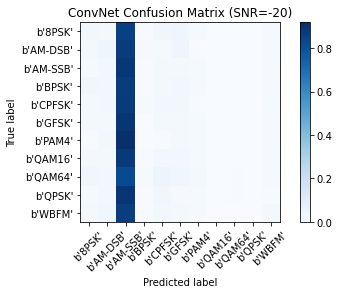

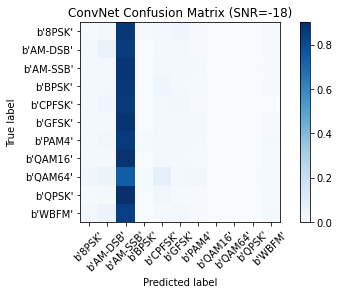

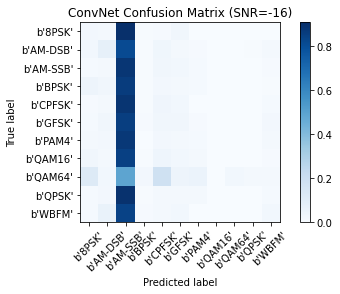

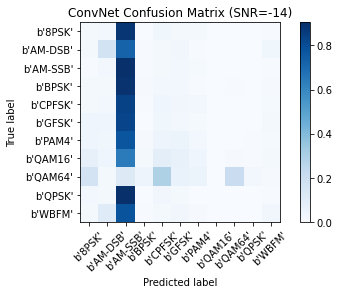

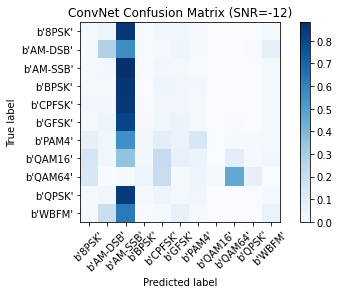

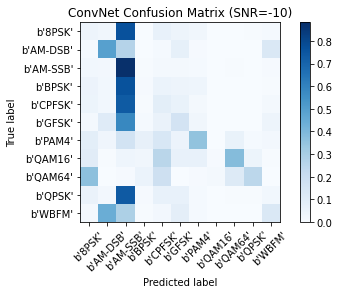

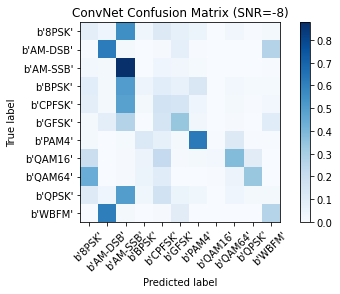

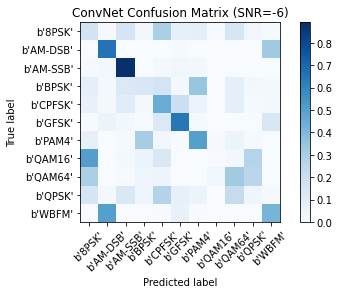

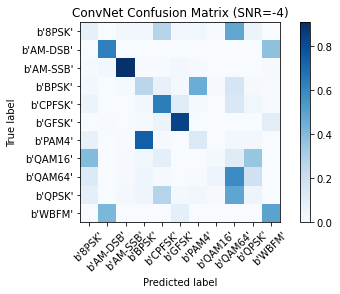

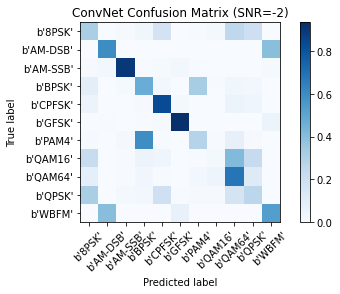

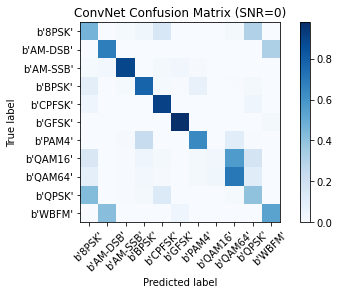

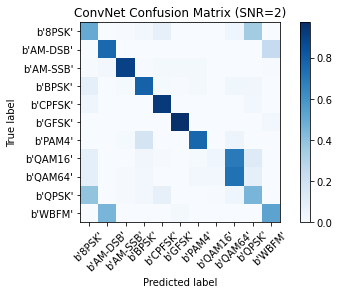

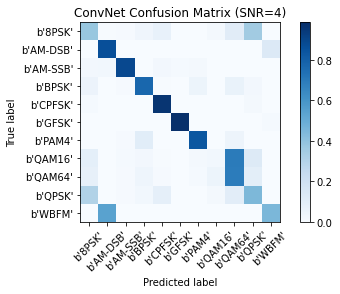

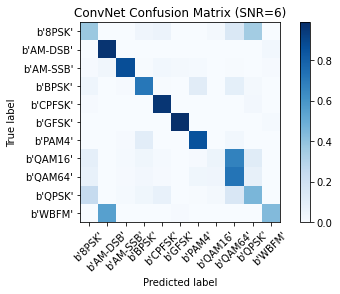

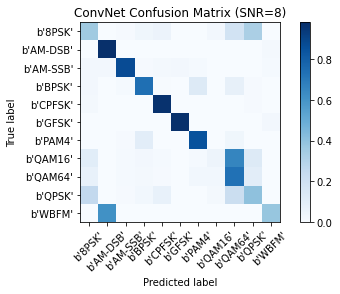

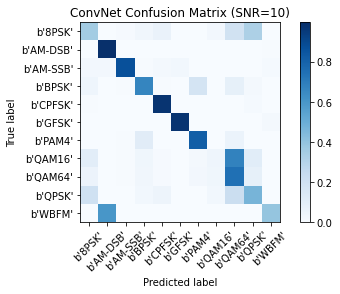

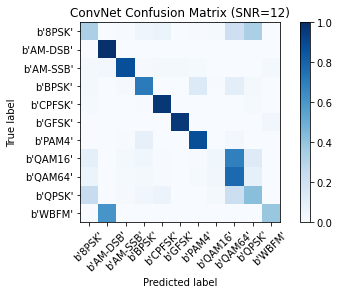

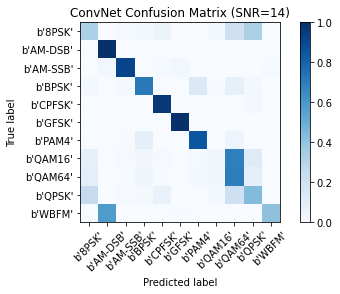

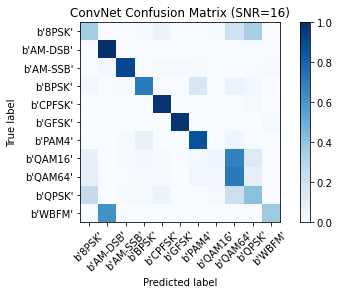

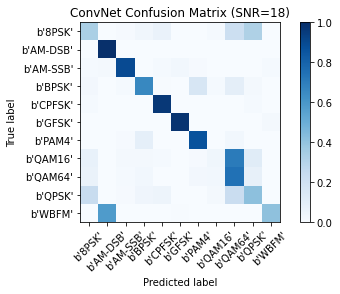

In [55]:
acc = getTestAccArray(model, lbl, X_test, y_test, test_idx)

Text(0.5, 1.0, 'Accuracy vs SNRs')

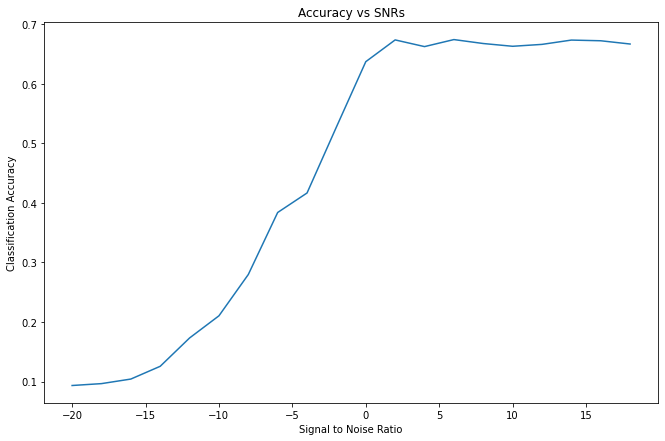

In [56]:
# Plot accuracy curve
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')